<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-Projects/blob/main/Amazon-Reviews-Analysis/amazon_products_review_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset

In [2]:
import os
from google.colab import userdata

os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

!mkdir ~/kaggle
!cp kaggle.json ~/kaggle/
!chmod 600 ~/kaggle/kaggle.json
#!/bin/bash
!kaggle datasets download snap/amazon-fine-food-reviews
!unzip amazon-fine-food-reviews.zip
!rm amazon-fine-food-reviews.zip

mkdir: cannot create directory ‘/root/kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0
 56% 136M/242M [00:00<00:00, 1.42GB/s]
100% 242M/242M [00:00<00:00, 700MB/s] 
Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Load & Analyze Data

In [3]:
# Load Dataset
df = pd.read_csv("Reviews.csv")

> Analyze Dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
# Check few samples for summary
df['Summary'][:5].values

array(['Good Quality Dog Food', 'Not as Advertised',
       '"Delight" says it all', 'Cough Medicine', 'Great taffy'],
      dtype=object)

In [6]:
# Full review
df['Text'][:5].values

array(['I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.',
       'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".',
       'This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis\' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.',
    

In [9]:
# scores distribution
df['Score'].value_counts().index

Index([5, 4, 1, 3, 2], dtype='int64', name='Score')

> Visualization

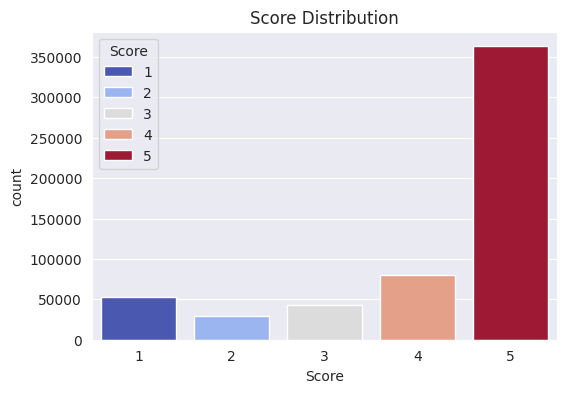

In [18]:
plt.figure(figsize=(6, 4))
sns.set_style("darkgrid")
sns.countplot(
    data=df,
    x='Score',
    palette='coolwarm',
    hue="Score")
plt.title("Score Distribution")
plt.show()

# Dataset Preprocessing

In [20]:
df_filtered = df[['Text', 'Score']].copy()
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    568454 non-null  object
 1   Score   568454 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ MB


In [21]:
# check NaNs
df_filtered.isna().sum()

,0
Text,0
Score,0


In [22]:
# Labeling
# Binary classification
df_filtered['Score_bin'] = df_filtered['Score'].apply(lambda x: 1 if x > 3 else 0)

In [26]:
df_filtered['Score_bin'].value_counts()

,count
Score_bin,
1,443777
0,124677


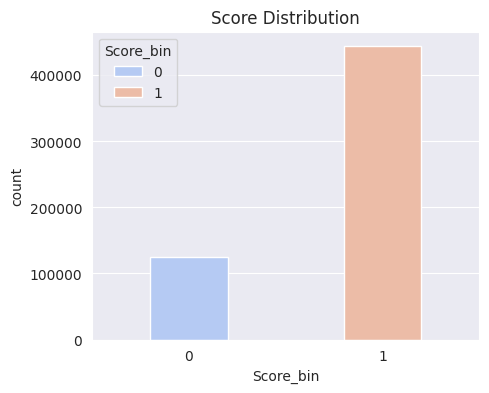

In [30]:
plt.figure(figsize=(5, 4))
sns.set_style("darkgrid")
sns.countplot(
    data=df_filtered,
    x='Score_bin',
    palette='coolwarm',
    hue="Score_bin",
    width=0.4)
plt.title("Score Distribution")
plt.show()

## Data Sampling

In [31]:
# Separate data by Score_bin
df_zeros = df_filtered[df_filtered['Score_bin'] == 0]
df_ones = df_filtered[df_filtered['Score_bin'] == 1]

# Determine the number of samples for each class for a balanced dataset
num_samples_per_class = 25000

# Sample equally from each class
df_zeros_sampled = df_zeros.sample(n=num_samples_per_class, random_state=42)
df_ones_sampled = df_ones.sample(n=num_samples_per_class, random_state=42)

# Concatenate the sampled dataframes
df_balanced_sampled = pd.concat([df_zeros_sampled, df_ones_sampled])

# Shuffle the combined dataframe
df_balanced_sampled = df_balanced_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

print("Shape of the balanced sampled data:")
print(df_balanced_sampled.shape)
print("\nDistribution of Score_bin in the balanced sampled data:")
print(df_balanced_sampled['Score_bin'].value_counts())

Shape of the balanced sampled data:
(50000, 3)

Distribution of Score_bin in the balanced sampled data:
Score_bin
1    25000
0    25000
Name: count, dtype: int64


# Text Cleaning

In [36]:
# Text Cleaning
import re

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s\']', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df_balanced_sampled['Clean_Text'] = df_balanced_sampled["Text"].apply(clean_text)

In [37]:
# Update X to be the balanced sampled text data
X = df_balanced_sampled['Clean_Text']
y = df_balanced_sampled['Score_bin']

In [39]:
print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (50000,)
y: (50000,)


## Train/Test/Val Data

In [40]:
from sklearn.model_selection import train_test_split

# Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Train/Val
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"X_val: {X_val.shape}")

X_train: (36000,)
X_test: (10000,)
X_val: (4000,)


# Text Preprocessing

Mean Length: 81.82058333333333
Median Length: 59.0
Max Length: 2013
Min Length: 2
90th Percentile: 163.0
95th Percentile: 219.0
99th Percentile: 380.0200000000041



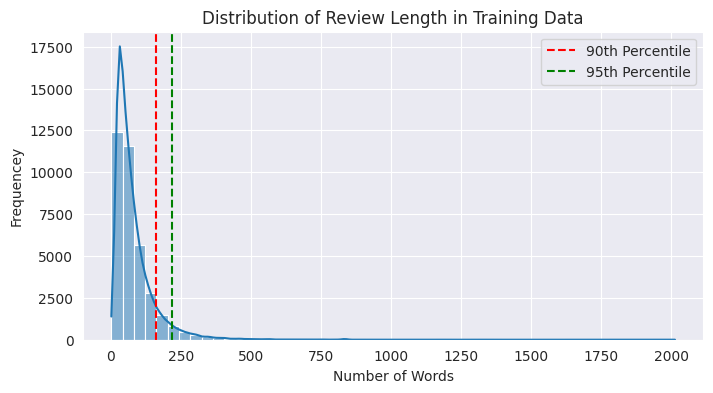

In [51]:
# Choosing Max Len
review_length = X_train.apply(lambda x: len(x.split()))

# Anaylsis
print(f"Mean Length: {review_length.mean()}")
print(f"Median Length: {review_length.median()}")
print(f"Max Length: {review_length.max()}")
print(f"Min Length: {review_length.min()}")

# Check percentiles
print(f"90th Percentile: {review_length.quantile(0.9)}")
print(f"95th Percentile: {review_length.quantile(0.95)}")
print(f"99th Percentile: {review_length.quantile(0.99)}")

# Visulization
print()
plt.figure(figsize=(8, 4))
sns.histplot(review_length, bins=50, kde=True)
plt.title("Distribution of Review Length in Training Data")
plt.xlabel("Number of Words")
plt.ylabel("Frequencey")
plt.axvline(np.percentile(review_length, 90), color='red', linestyle='--', label='90th Percentile')
plt.axvline(np.percentile(review_length, 95), color='green', linestyle='--', label='95th Percentile')
plt.legend()
plt.show()

## Tokenization

In [52]:
from tensorflow.keras.layers import TextVectorization

VOCAB_SIZE = 1000
MAX_LEN = 220
EMBEDDING_DIM = 128

text_vectorizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN,
)

# Adapting vectorizer on training data
text_vectorizer.adapt(X_train.to_numpy())
# Check few words
print("Vocabulary (first 10 words):", text_vectorizer.get_vocabulary()[:10])

Vocabulary (first 10 words): ['', '[UNK]', np.str_('the'), np.str_('i'), np.str_('and'), np.str_('a'), np.str_('to'), np.str_('it'), np.str_('of'), np.str_('is')]


# Model Definition

In [54]:
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential

model = Sequential([
    tf.keras.Input(shape=(1, ), dtype=tf.string),
    text_vectorizer,
    Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        mask_zero=True
    ),
    LSTM(64),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 220)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 220, 128)       │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,633 (709.50 KB)

 Trainable params: 181,633 (709.50 KB)

 Non-trainable params: 0 (0.00 B)

# Training

In [55]:
history = model.fit(
    X_train.to_numpy(), y_train.to_numpy(),
    epochs=10,
    batch_size=64,
    validation_data=(X_val.to_numpy(), y_val.to_numpy()),
    verbose=1
)

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 203s 355ms/step - loss: 0.5218 - val_loss: 0.4150
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 201s 357ms/step - loss: 0.3904 - val_loss: 0.4117
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 197s 350ms/step - loss: 0.3456 - val_loss: 0.3476
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 201s 357ms/step - loss: 0.3126 - val_loss: 0.3495
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 191s 338ms/step - loss: 0.2936 - val_loss: 0.3455
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 193s 343ms/step - loss: 0.2784 - val_loss: 0.3370
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 196s 348ms/step - loss: 0.2673 - val_loss: 0.3382
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 196s 349ms/step - loss: 0.2539 - val_loss: 0.3565
Epoch 9/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 199s 354ms/step - loss: 0.2342 - val_loss: 0.3703
Epoch 10/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 198s 346ms/step - loss: 0.2180 - val_loss: 0.3689


# Evaluation

In [59]:
loss = model.evaluate(X_test.to_numpy(), y_test.to_numpy())
print(f"Test Loss: {loss:.4f}")

# Calculate accuracy
y_pred = model.predict(X_test.to_numpy())
y_pred_binary = (y_pred > 0.5).astype(int)
acc = (y_pred_binary == y_test.to_numpy()).mean()
print(f"Test Accuracy: {acc:.4f}")

# Prediction on new, unseen examples
new_reviews = [
    # Positive
    "This was the best movie I have ever seen, truly a masterpiece!",
    # Negative
    "A complete waste of time. The acting was terrible and the plot was boring.",
    # Neutral => Consider this review as Negative comment.
    "It was an okay movie, not great but not bad either."
]

# Convert the list of new reviews to a numpy array with object dtype
new_reviews_array = np.array(new_reviews, dtype=object)

predictions = model.predict(new_reviews_array)

for review, pred in zip(new_reviews, predictions):
    sentiment = "Positive" if pred > 0.5 else "Negative"
    print(f"\n\nReview: '{review}'")
    print(f"Prediction Score: {pred[0]:.4f} --> Sentiment: {sentiment}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 0.3722
Test Loss: 0.3646
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step
Test Accuracy: 0.4999
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Review: 'This was the best movie I have ever seen, truly a masterpiece!'
Prediction Score: 0.9666 --> Sentiment: Positive


Review: 'A complete waste of time. The acting was terrible and the plot was boring.'
Prediction Score: 0.0061 --> Sentiment: Negative


Review: 'It was an okay movie, not great but not bad either.'
Prediction Score: 0.0204 --> Sentiment: Negative
